In [108]:
%matplotlib inline
import sys
sys.path.append("/Users/Daniel/Rigetti/pyquil") # CHANGE THIS TO YOUR ABSOLUTE PATH TO THE PYQUIL FOLDER

In [109]:
import pyquil

In [110]:
from pyquil.quil import Program 
from pyquil.gates import *
from pyquil.api import QVMConnection
from pyquil.paulis import ID, sX, sY, sZ

In [111]:
import numpy as np
import scipy
from scipy.linalg import expm, sinm, cosm, logm

In [112]:
K = np.array([[0.5065, 0.2425], 
              [0.2425, 0.4935]])
gamma = 1000
F = K + 1/gamma*np.eye(2)
print(F)

[[ 0.5075  0.2425]
 [ 0.2425  0.4945]]


In [122]:
class Inverse():
    def __init__(self, F, program, qvm, theta0, theta1, theta2):
        self.F = F
        self.program = program
        self.qvm = qvm
        self.first, self.second, self.y, self.anc = (0,1,2,3)
        
        self.theta0 = theta0
        self.theta1 = theta1
        self.theta2 = theta2

#     def expmatrix(self, val,matrix):  
#         return expm(val*1j*self.F)
    
    def controlMake(self, M):
        """Creates control gates from M.
        param:
            M: (matrix) to control
        returns:
            (matrix) controlled."""
        zero = np.zeros((2,2))
        I = np.eye(2)
        top = np.concatenate((I, zero), axis = 1)
        bottom = np.concatenate((zero, M), axis = 1)
        res = np.concatenate((top, bottom), axis = 0)
        return res
    
    def CRY(self, angle):
        """Creates control RY gate.
        param:
            angle: (float) by how much to rotate
        returns:
            matrix."""
        Y = np.array([[0, -1j], [1j, 0]])
        expY = expm(-angle/2. * 1j * Y)
        return self.controlMake(expY)
    
    def CCRY(self, angle):
        Y = np.array([[0, -1j], [1j, 0]])
        expY = expm(-angle/2. * 1j * Y)
        
        ccry = np.eye(8, dtype='cfloat')
        ccry[6][6] = expY[0][0]
        ccry[6][7] = expY[0][1]
        ccry[7][6] = expY[1][0]
        ccry[7][7] = expY[1][1]

        return ccry
    
    def NCCRY(self, angle):
        Y = np.array([[0, -1j], [1j, 0]])
        expY = expm(-angle/2. * 1j * Y)
        
        cncry = np.eye(8, dtype='cfloat')
        cncry[2][2] = expY[0][0]
        cncry[2][3] = expY[0][1]
        cncry[3][2] = expY[1][0]
        cncry[3][3] = expY[1][1]
        
        return cncry
        
    def HGate(self):
        return self.controlMake(np.sqrt(0.5) * np.array([[1,1], [1,-1]]))
    
    
    def main(self):
        print(self.F)
        self.program += RY(-np.pi / 2 , self.y)
        
        print("self.y", self.qvm.wavefunction(self.program))
        
        # =============================================
        # Inversion 
        # =============================================
        # add hadamards
        self.program += H(self.first)
        self.program += H(self.second)
        

        
        # add the exponent gates
        expF = expm(np.pi*1j*self.F)
        expF = self.controlMake(expF)
        self.program = self.program.defgate("expF", expF)
        self.program.inst(("expF", self.first, self.y))
        
        expFhalf = expm(np.pi/2.*1j*self.F)
        expFhalf = self.controlMake(expFhalf)
        self.program = self.program.defgate("expFhalf", expFhalf)
        self.program.inst(("expFhalf", self.second, self.y))
        
        self.program += SWAP(self.first, self.second)
        self.program += H(self.second)
        
        #S inverse
        self.program += CPHASE(-np.pi/2, self.second, self.first) # right order of qubits?
        
        self.program += H(self.first)
        
        self.program += SWAP(self.first, self.second)
                
        CRYpi4 = self.CRY(np.pi/4.)
        self.program = self.program.defgate("CRYpi4", CRYpi4)
        self.program.inst(("CRYpi4", self.first, self.anc))    
        
        CRYpi2 = self.CRY(np.pi/2.)
        self.program = self.program.defgate("CRYpi2", CRYpi2)
        self.program.inst(("CRYpi2", self.second, self.anc))
        
        
                
        self.program += SWAP(self.first, self.second)


            
        self.program += H(self.first)
        
        self.program += CPHASE(np.pi/2, self.second, self.first) # right order of qubits?
        
        self.program += H(self.second)
        
        self.program += SWAP(self.first, self.second)
        
        minusExpFhalf = expm(-np.pi/2.*1j*self.F)
        minusExpFhalf = self.controlMake(minusExpFhalf)
        self.program = self.program.defgate("minusExpFhalf", minusExpFhalf)
        self.program.inst(("minusExpFhalf", self.second, self.y))
        
        minusExpF = expm(-np.pi*1j*self.F)
        minusExpF = self.controlMake(minusExpF)
        self.program = self.program.defgate("minusExpF", minusExpF)
        self.program.inst(("minusExpF", self.first, self.y))
        
        self.program += H(self.first)
        self.program += H(self.second)
        
        print(self.program)
        
#         self.program += MEASURE(self.first, 0)
#         self.program += MEASURE(self.second, 1)
#         self.program += MEASURE(self.y, 2)
#         self.program += MEASURE(self.anc, 3)


        
        print(self.qvm.wavefunction(self.program))
#         print(self.qvm.run(self.program, [0, 1, 2, 3], 10))
        
        print("inversion done")


        
        # =============================================
        # Training Data Orcale 
        # =============================================
        
        theta1Gate = self.NCCRY(self.theta1)
        self.program = self.program.defgate("theta1Gate", theta1Gate)
        self.program.inst(("theta1Gate", self.anc, self.y, self.second))
        
        theta2Gate = self.CCRY(self.theta2)
        self.program = self.program.defgate("theta2Gate", theta2Gate)
        self.program.inst(("theta2Gate", self.anc, self.y, self.second))
        
        # =============================================
        # U_x0
        # =============================================
        
        theta0Gate = self.CRY(-self.theta0)
        self.program = self.program.defgate("theta0Gate", theta0Gate)
        self.program.inst(("theta0Gate", self.anc, self.second))
        
        CH = self.HGate()
        self.program = self.program.defgate("CH", CH)
        self.program.inst(("CH", self.anc, self.y))
        
        # =============================================
        # MEASUREMENT
        # =============================================
        
        self.program += SWAP(self.first, self.anc)
        
#         print(self.qvm.wavefunction(self.program))


        
        self.program += MEASURE(self.anc, 0)
        
#         while True:
#             wavefunction = self.qvm.wavefunction(self.program)
#             if np.real(wavefunction.amplitudes[0]) == 0 and np.imag(wavefunction.amplitudes[0]) == 0:
#                 return wavefunction
        

        
        
        


        


In [123]:
def classify(wavefunction):
    print(np.real(wavefunction.amplitudes[9]))
    if np.real(wavefunction.amplitudes[9]) > 0:
        return 9
    else:
        return 6

In [124]:
# 9-train
F = np.array([[2/4, 1/4], [1/4,2/4]])
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(0.354/0.935)), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
# print(wavefunction)
# print("Classified as: ", classify(wavefunction))

[[ 0.5   0.25]
 [ 0.25  0.5 ]]
self.y (0.7071067812+0j)|0> + (-0.7071067812+0j)|1>
DEFGATE expF:
    1.0, 0.0, 0.0, 0.0
    0.0, 1.0, 0.0, 0.0
    0.0, 0.0, 4.67797817633918e-17+0.70710678118654746i, -0.70710678118654757
    0.0, 0.0, -0.70710678118654746+3.9936180837827239e-17i, 3.9936180837827239e-17+0.70710678118654746i

DEFGATE expFhalf:
    1.0, 0.0, 0.0, 0.0
    0.0, 1.0, 0.0, 0.0
    0.0, 0.0, 0.65328148243818829+0.65328148243818818i, -0.27059805007309845+0.27059805007309845i
    0.0, 0.0, -0.27059805007309851+0.27059805007309851i, 0.65328148243818829+0.65328148243818818i

DEFGATE CRYpi4:
    1.0, 0.0, 0.0, 0.0
    0.0, 1.0, 0.0, 0.0
    0.0, 0.0, 0.92387953251128674, -0.38268343236508978
    0.0, 0.0, 0.38268343236508978, 0.92387953251128663

DEFGATE CRYpi2:
    1.0, 0.0, 0.0, 0.0
    0.0, 1.0, 0.0, 0.0
    0.0, 0.0, 0.70710678118654757, -0.70710678118654757
    0.0, 0.0, 0.70710678118654757, 0.70710678118654757

DEFGATE minusExpFhalf:
    1.0, 0.0, 0.0, 0.0
    0.0, 1.0, 0.0, 

In [103]:
x = np.linalg.inv(F).dot(np.array([1/np.sqrt(2), -1/np.sqrt(2)]))
print(x)
F.dot(x)

[ 2.7121047  -2.75994372]


array([ 0.70710678, -0.70710678])

In [127]:
# 6-train
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
print(wavefunction)
print("Classified as: ", classify(wavefunction))

-0.4753547997j|1000> + (-0.0432099514-0.1120622394j)|1001> + (0.6396312069+0j)|1010> + (0.3246516699+0.0184470816j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.0783604159-0.1408428878j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.1145577967+0.0017932214j)|1111>
-0.04320995140727065
Classified as:  6


In [128]:
# 9-test1
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(0.147/0.989)), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
print(wavefunction)
print("Classified as: ", classify(wavefunction))

-0.4753547997j|1000> + (0.1568582054-0.0795388313j)|1001> + (0.6396312069+0j)|1010> + (0.2875088+0.0810667295j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.1308899502-0.1125997123j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.0461699521+0.084624107j)|1111>
0.15685820539207548
Classified as:  9


In [129]:
# 6-test1
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(0.997/-0.072)), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
print(wavefunction)
print("Classified as: ", classify(wavefunction))

-0.4753547997j|1000> + (-0.0804651475-0.1134436957j)|1001> + (0.6396312069+0j)|1010> + (0.3174762459+0.0053636015j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.0645863323-0.1401052599j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.1228513298-0.0145069239j)|1111>
-0.08046514748359092
Classified as:  6


In [130]:
# 9-test2
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(0.338/0.941)), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
print(wavefunction)
print("Classified as: ", classify(wavefunction))

-0.4753547997j|1000> + (0.1277809595-0.0871358635j)|1001> + (0.6396312069+0j)|1010> + (0.3015590043+0.0728394235j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.1257067064-0.1203863679j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.0588359373+0.0731235743j)|1111>
0.1277809595169964
Classified as:  9


In [131]:
# 6-test2
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(0.999/0.025)), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
print(wavefunction)
print("Classified as: ", classify(wavefunction))

-0.4753547997j|1000> + (-0.0649611026-0.1130496608j)|1001> + (0.6396312069+0j)|1010> + (0.3210075729+0.0108634483j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.0704729939-0.140644249j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.1195717387-0.0076895969j)|1111>
-0.06496110255767043
Classified as:  6


In [62]:
# PROCESSING
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np

def downsize(img):
    return img.resize((28, 28), Image.ANTIALIAS)

def get_HR(img):
    """Dark pixels in left half / Dark pixels in right half."""
    left_total, right_total = 0, 0
    width, height = img.size
    
    for x in range(width):
        for y in range(height):
            r, g, b, a = img.getpixel((x, y))
            brightness = (r + g + b) / 3
            if x < (width / 2):
                left_total += 1 - (brightness / 255)
            else:
                right_total += 1 - (brightness / 255)
    
    return left_total / right_total

def get_VR(img):
    """Dark pixels in top half / Dark pixels in bottom half."""
    top_total, bottom_total = 0, 0
    width, height = img.size
    
    for x in range(width):
        for y in range(height):
            r, g, b, a = img.getpixel((x, y))
            brightness = (r + g + b) / 3
            if y < (height / 2):
                bottom_total += 1 - (brightness / 255)
            else:
                top_total += 1 - (brightness / 255)
    
    return bottom_total / top_total

def load_image(path):
    return Image.open(path)

def full_process(img):
    """Features HR, VR as an array."""
    img = downsize(img)
    return [get_HR(img) * 1.4, get_VR(img) * 0.6]

In [132]:
# 9-processed
img_9 = load_image("9.png")
features_9 = full_process(img_9)
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(features_9[0]/features_9[1])), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
print(wavefunction)
print("Classified as: ", classify(wavefunction))

-0.4753547997j|1000> + (0.0284177714-0.105369661j)|1001> + (0.6396312069+0j)|1010> + (0.3262793848+0.0423730439j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.1013954549-0.1370829594j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.0947776624+0.0323758697j)|1111>
0.028417771366276864
Classified as:  9


In [133]:
# 6-processed
img_6 = load_image("6.png")
features_6 = full_process(img_6)
print(features_6)
inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(features_6[0]/features_6[1])), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
wavefunction = inverse.main()
print(wavefunction)
print("Classified as: ", classify(wavefunction))

[1.8255215123859179, 0.46847939535720756]
-0.4753547997j|1000> + (-0.0283195988-0.1111015035j)|1001> + (0.6396312069+0j)|1010> + (0.3262879204+0.0235519898j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.0835167676-0.1406135687j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.1108548289+0.0082315852j)|1111>
-0.02831959876324158
Classified as:  6


In [110]:
img_6 = load_image("6.png")
features_6 = full_process(img_6)
while True:
    inverse = Inverse(F, Program(), QVMConnection(), np.arctan(1/(features_6[0]/features_6[1])), np.arctan(1/(0.987/0.159)), np.arctan(1/(0.354/0.935)))
    wavefunction = inverse.main()
    if np.real(wavefunction.amplitudes[0]) == 0 and np.imag(wavefunction.amplitudes[0]) == 0:
        print(wavefunction)
        print("Classified as: ", classify(wavefunction))
        break

-0.4753547997j|1000> + (-0.0283195988-0.1111015035j)|1001> + (0.6396312069+0j)|1010> + (0.3262879204+0.0235519898j)|1011> + (-0.0361663209-0.0108206482j)|1100> + (0.0835167676-0.1406135687j)|1101> + (0.4519027209-0.0008659896j)|1110> + (0.1108548289+0.0082315852j)|1111>
-0.02831959876324158
Classified as:  6


In [64]:
def main2():    
    path_6 = "6.png"
    img_6 = load_image(path_6)
    path_9 = "9.png"
    img_9 = load_image(path_9)
    img_list_6 = [img_6]
    img_list_9 = [img_9]
    n_correct = 0
    n_rep = 5
    

    # first index is correct class
    # all examples from paper
    query_list = [[6, [0.997,-0.072]], [9, [0.147,0.989]], [6, [0.999,-0.030]], [6, [0.987,-0.161]],
                 [9, [0.338,0.941]], [6, [0.999,0.025]], [9, [0.439,0.899]], [9, [0.173,0.985]]]
    # add 6s from images
    for el in img_list_6:
        query_list.append([6, full_process(el)])
    # add 9s from images
    for el in img_list_9:
        query_list.append([9, full_process(el)])
        
    i_c = 0
    for j in range(n_rep):
        for i, el in enumerate(query_list):
            print("{}: Features {}".format(el[0], el[1]))
            result = query(el[1])
            if(result  == el[0]):
                n_correct += 1
            i_c += 1
            print("[" + str(i) + "]" + " Classified as", str(result), ". Correct: " + str(result  == el[0]))
            print("So far " + str(n_correct) + "/" + str(i_c))

    print("Classified correctly ", str(n_correct), "out of ", str(i_c))

In [20]:
def query(q):

    train6 = [0.987, 0.159]
    train9 = [0.354, 0.935]
    theta1 = calc_theta(train6)
    theta2 = calc_theta(train9)

   
    theta0 = calc_theta(q)

    inverse = Inverse(F, Program(), QVMConnection(), theta0, theta1, theta2)
    amplitudes = inverse.main().amplitudes

    

    if(np.real(amplitudes[9]) > 0):
        return 9
    else:
        return 6



In [10]:
def calc_theta(x_i):
    # ArcCot[z] is equal to ArcTan[1/z] for complex z, so also R
    theta = np.arctan(1/(x_i[0]/x_i[1]))
    return theta

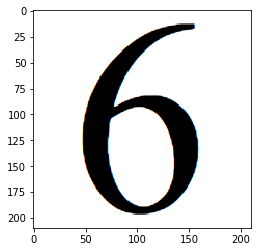

In [153]:
imshow(load_image("6.png"))

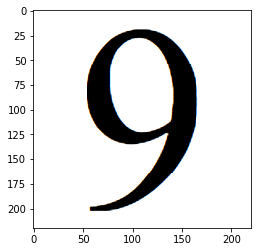

In [154]:
imshow(load_image("9.png"))

In [65]:
main2()

6: Features [0.997, -0.072]
[0.997, -0.072]
[0] Classified as 6 . Correct: True
So far 1/1
9: Features [0.147, 0.989]
[0.147, 0.989]
[1] Classified as 9 . Correct: True
So far 2/2
6: Features [0.999, -0.03]
[0.999, -0.03]
[2] Classified as 6 . Correct: True
So far 3/3
6: Features [0.987, -0.161]
[0.987, -0.161]
[3] Classified as 6 . Correct: True
So far 4/4
9: Features [0.338, 0.941]
[0.338, 0.941]
[4] Classified as 9 . Correct: True
So far 5/5
6: Features [0.999, 0.025]
[0.999, 0.025]
[5] Classified as 6 . Correct: True
So far 6/6
9: Features [0.439, 0.899]
[0.439, 0.899]
[6] Classified as 9 . Correct: True
So far 7/7
9: Features [0.173, 0.985]
[0.173, 0.985]
[7] Classified as 9 . Correct: True
So far 8/8
6: Features [1.8255215123859179, 0.46847939535720756]
[1.8255215123859179, 0.46847939535720756]
[8] Classified as 6 . Correct: True
So far 9/9
9: Features [1.1083632490433544, 0.7552068828327032]
[1.1083632490433544, 0.7552068828327032]
[9] Classified as 9 . Correct: True
So far 10/1